Для предсказания продаж используется модель Prophet. 

In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sys
import os

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

pd.options.mode.copy_on_write = False
sys.path.append(os.path.dirname(os.getcwd())) # define path to the project for convenoent relative import

Считываем подготовленный на предыдущем этапе датасет:

In [2]:
df = pd.read_csv('../data/prepared_dataset.csv', index_col = 0)
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3643 entries, 4003 to 39777
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   part_number  3643 non-null   object        
 1   ds           3643 non-null   datetime64[ns]
 2   name         3643 non-null   object        
 3   y            3643 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 142.3+ KB


In [3]:
df.part_number.unique()

array(['E-2SN-208-G40-X00-Y9', 'E-2SN-376-P15-X00-Y12',
       'E-2SN-377-P15-X00-Y12', 'E-2SN-389-P18-X00-Y14',
       'E-2SN-390-P18-X00-Y14', 'E-4KF-104-D50-X00-Y5',
       'E-4KF-128-K15-X00-Y6', 'E-4KF-404-P25-X00-Y10',
       'E-4KF-424-P02-X00-Y8', 'E-4KF-440-P00-X00-Y4',
       'E-4KF-441-P00-X00-Y4', 'E-4KF-451-P50-X00-Y7',
       'E-4KF-469-F01-X00-Y4', 'E-4KF-475-P50-X00-Y6'], dtype=object)

In [4]:
def plot_revenue(df: pd.DataFrame):
    for part_number in df.part_number.unique():
        df_part_number = df[df['part_number'] == part_number]
        plt.plot(df_part_number['ds'], df_part_number['y'], alpha=0.5)

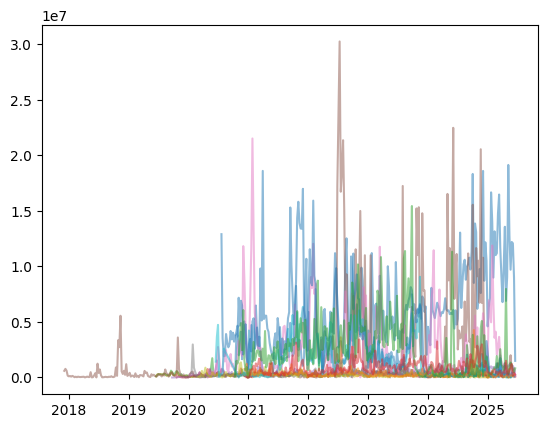

In [5]:
plot_revenue(df)

In [6]:
part_number = 'E-2SN-208-G40-X00-Y9'
df_part_number = df[df['part_number'] == part_number]
df_part_number = df_part_number.sort_values(by=['ds'])
start_date = df_part_number.iloc[0]['ds']
# # Стартовая дата
# start_date = pd.to_datetime('30.12.2013', format='%d.%m.%Y')
# # Сквозная нумерация недель
df_part_number['week_index'] = ((df_part_number['ds'] - start_date).dt.days // 7) + 1
df_part_number = df_part_number.sort_values(by=['week_index'])

In [7]:
df_part_number

,part_number,ds,name,y,week_index
4003,E-2SN-208-G40-X00-Y9,2020-07-20,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",12908160.00,1
4004,E-2SN-208-G40-X00-Y9,2020-07-27,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",3525840.00,2
4005,E-2SN-208-G40-X00-Y9,2020-08-03,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",1912320.00,3
4006,E-2SN-208-G40-X00-Y9,2020-08-10,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",1942200.00,4
4007,E-2SN-208-G40-X00-Y9,2020-08-17,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",3914280.00,5
...,...,...,...,...,...
4243,E-2SN-208-G40-X00-Y9,2025-05-19,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",9710233.12,253
4244,E-2SN-208-G40-X00-Y9,2025-05-26,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",12206069.99,254
4245,E-2SN-208-G40-X00-Y9,2025-06-02,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",12086844.56,255
4246,E-2SN-208-G40-X00-Y9,2025-06-09,"Снэки ""Трубочки хрустящие со вкусом сгущенного...",8976325.42,256


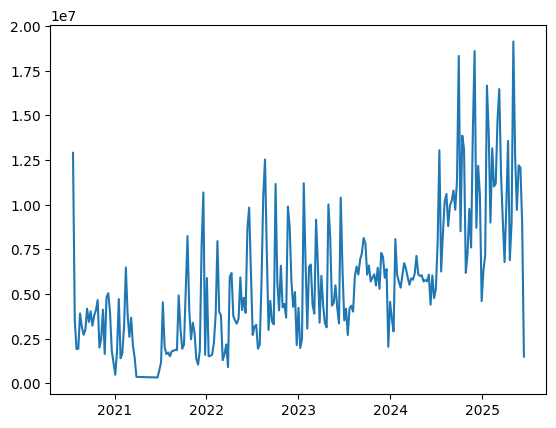

In [8]:
plt.plot(df_part_number['ds'], df_part_number['y'])

In [29]:
class ProphetPredictor:
    def __init__(self,  **model_params):
        """
        Инициализация класса с возможностью передачи параметров Prophet.
        """
        self.model_params = model_params
        self.model = None
        
    
    @staticmethod
    def get_season(date):
        if date.month in [12, 1, 2]:
            return 'winter'
        elif date.month in [3, 4, 5]:
            return 'spring'
        elif date.month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    def preprocess(self, df):
        df.loc[:, 'weeks_to_newyear'] = df['ds'].apply(lambda d: (pd.Timestamp(year=d.year, month=1, day=1) - d).days // 7)
        df.loc[:, 'season'] = df['ds'].apply(self.get_season)
        # One-hot кодировка столбцов
        df = pd.concat([df, pd.get_dummies(df['season'])], axis=1)
        # Добавление праздников 
        years = range(df['ds'].dt.year.min(), df['ds'].dt.year.max() + 1)
        self.holidays = pd.DataFrame({
            'holiday': ['Новый год'] * len(years) + ['День Защитника Отечества'] * len(years) + ['Международный женский день'] * len(years),
            'ds': pd.to_datetime([f'{y}-01-01' for y in years] + [f'{y}-02-23' for y in years] + [f'{y}-03-08' for y in years]),
            'lower_window': -14, # за сколько дней до праздника учитывать влияние
            'upper_window': 7 # сколько дней после праздника учитывать влияние 
        })
        return df
    
    def add_future_regressors(self, future_df):
        future_df['weeks_to_newyear'] = future_df['ds'].apply(
            lambda d: (pd.Timestamp(year=d.year, month=1, day=1) - d).days // 7)
        future_df['season'] = future_df['ds'].apply(self.get_season)
        dummies = pd.get_dummies(future_df['season'])
        for season in ['winter', 'spring', 'summer', 'autumn']:
            if season not in dummies:
                dummies[season] = 0  # если сезон не встречался — добавить
        future_df = pd.concat([future_df, dummies[['winter', 'spring', 'summer', 'autumn']]], axis=1)
        return future_df


    def fit(self, df):
        """
        Обучает модель Prophet на переданном датасете.
        df: pandas.DataFrame с колонками 'ds' (дата) и 'y' (значение)
        """
        self.df = self.preprocess(df)
        self.model = Prophet(holidays=self.holidays, **self.model_params)
        self.model.add_regressor('weeks_to_newyear')
        for season in ['winter', 'spring', 'summer', 'autumn']:
            self.model.add_regressor(season)
        self.model.fit(self.df)

    def predict(self, future_df):
        """
        Получает прогноз модели на df, содержащем колонку 'ds' с будущими датами.
        Возвращает датафрейм с прогнозом.
        """
        if self.model is None:
            raise Exception("Сначала вызовите метод fit().")
        # Добавляем спец. регрессоры
        future_df = self.add_future_regressors(future_df)
        self.forecast = self.model.predict(future_df)
        return self.forecast

    def fit_predict(self, train_df, periods, freq='W'):
        """
        Обучает модель и сразу возвращает прогноз на указанное количество периодов.
        train_df: обучающий DataFrame с 'ds' и 'y'
        periods: сколько периодов вперёд прогнозировать
        freq: частота ('W' - недели, 'M' — месяцы)
        """
        self.fit(train_df)
        last_date = train_df['ds'].max()
        self.periods = periods
        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        return self.predict(future)
    
    def save_predict_plot(self, last_k=7*4):
        forecast_train = self.forecast[self.forecast['ds'].isin(df_part_number['ds'])]
        y_true = df_part_number.set_index('ds').loc[forecast_train['ds'], 'y']
        y_pred = forecast_train['yhat']

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)

        metrics_str = "RMSE: " + str(round(rmse, 0)) + '\n MAPE: ' + \
        str(round(mape, 2)*100) + '%'
        
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.text(0.2, 0.2, metrics_str, fontsize=14, transform=plt.gcf().transFigure)

        ax.plot(self.df['ds'][-last_k:], self.df['y'][-last_k:], label='Фактические значения')
        ax.plot(self.forecast['ds'][-self.periods - 1:], 
                self.forecast['yhat'][-self.periods - 1:], label='Прогноз')
        ax.vlines(self.df['ds'][-1:], 0, max(self.df['y'][-last_k:]), 
                  color='k', label = 'Граница доступных данных', 
                  linestyles = 'dashed')
        ax.fill_between(self.forecast['ds'][-self.periods - 1:], 
                        self.forecast['yhat_lower'][-self.periods - 1:], 
                        self.forecast['yhat_upper'][-self.periods - 1:], 
                        color='blue', alpha=0.2, label='Доверительный интервал')
        ax.legend(loc='upper left')
        ax.set_xlabel('Дата')
        ax.set_ylabel('Продажи, руб')
        ax.set_title(self.df['name'].unique()[0])
        # plt.xlim('')
        # ax.set_ylim(0, max(self.df['ds'][-last_k:]))
        file_name = 'forecast_' + self.df['name'].unique()[0] + '_' + \
                    str(max(self.df['y'][-last_k:]))
        file_name = file_name.replace('/', '')
        fig.savefig('../figures/' + file_name + '.png', dpi=600)
        fig.show()


/var/folders/z9/3mmkvbxj1g5gk4qrms1dj77h0000gn/T/ipykernel_73903/1196499382.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'weeks_to_newyear'] = df['ds'].apply(lambda d: (pd.Timestamp(year=d.year, month=1, day=1) - d).days // 7)
/var/folders/z9/3mmkvbxj1g5gk4qrms1dj77h0000gn/T/ipykernel_73903/1196499382.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'season'] = df['ds'].apply(self.get_season)
00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:24 - cmdstanpy - INFO

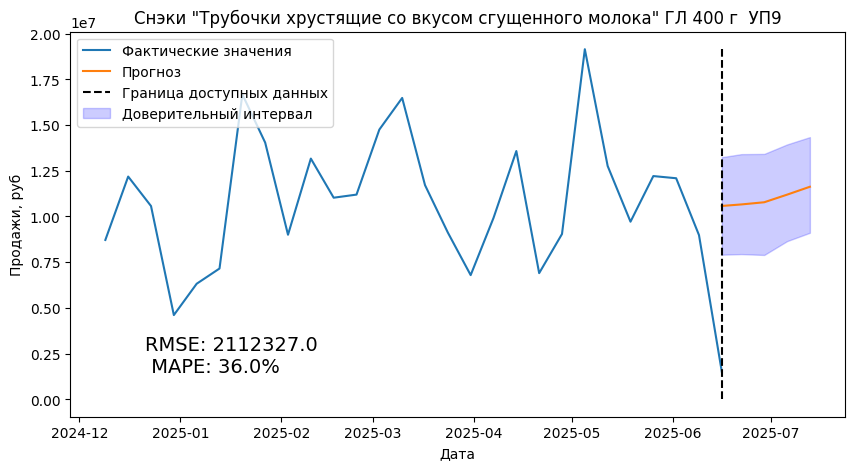

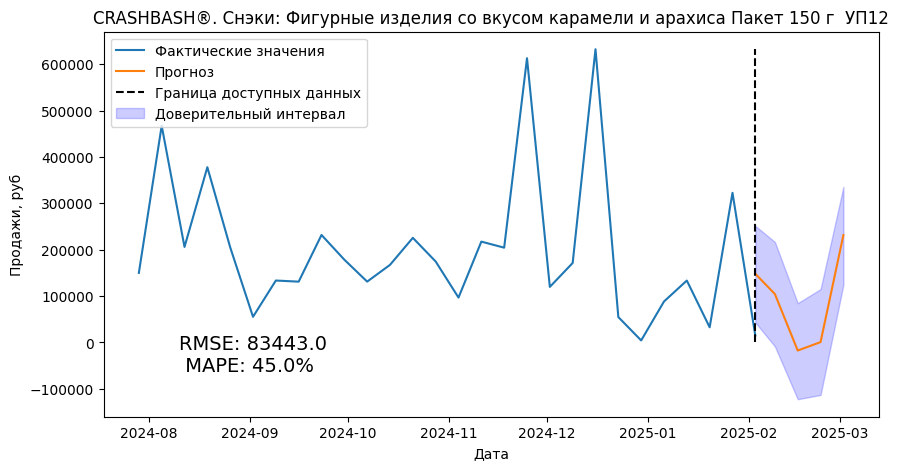

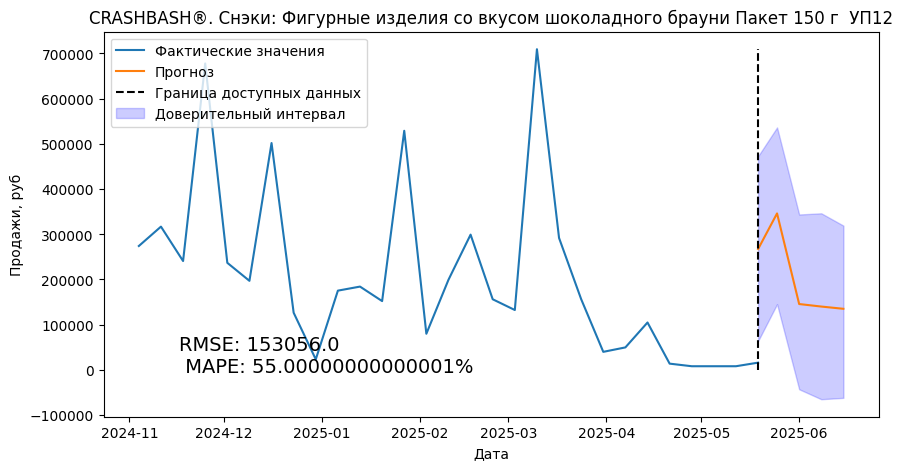

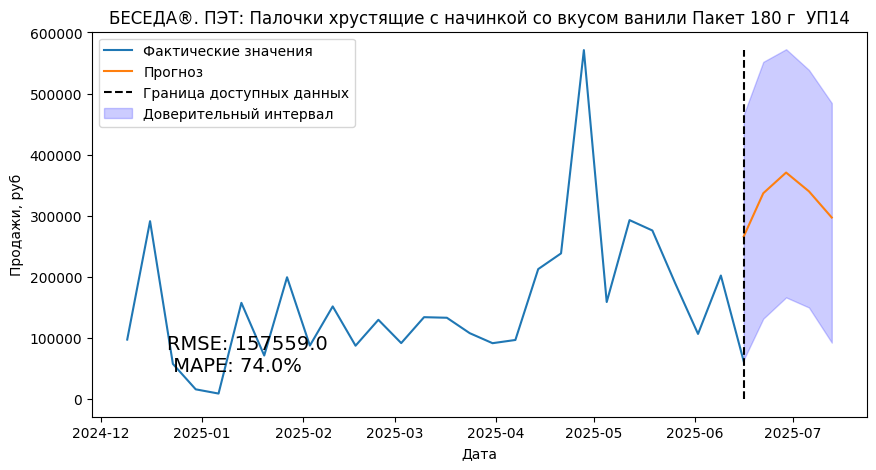

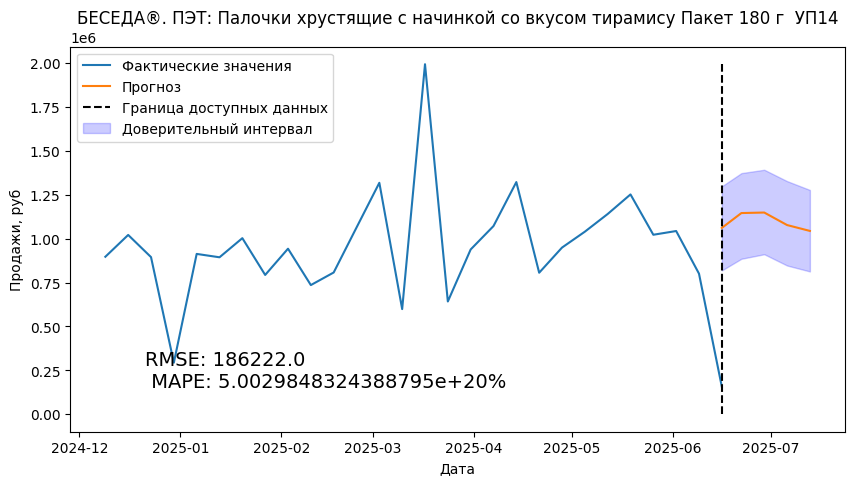

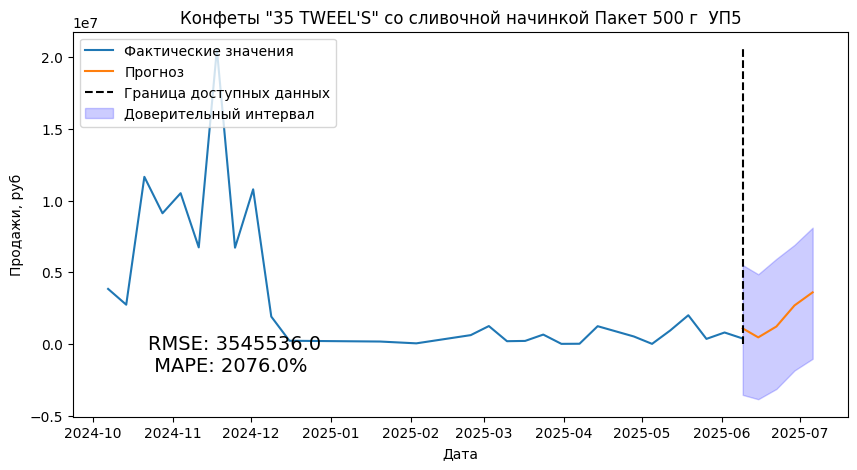

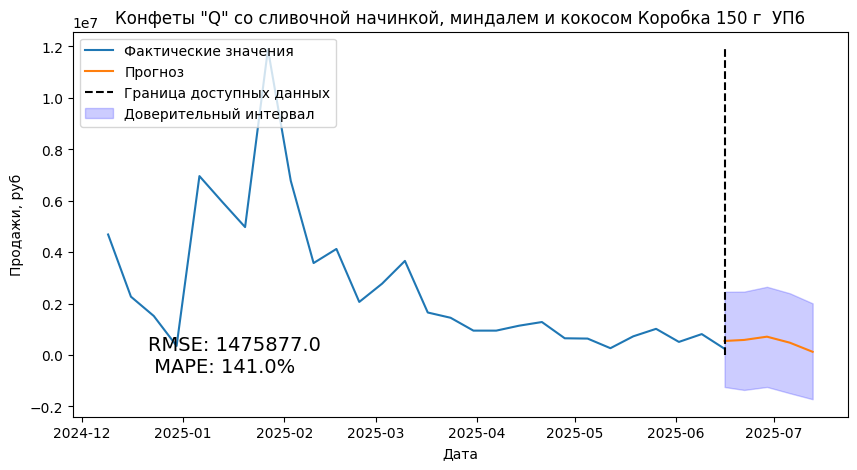

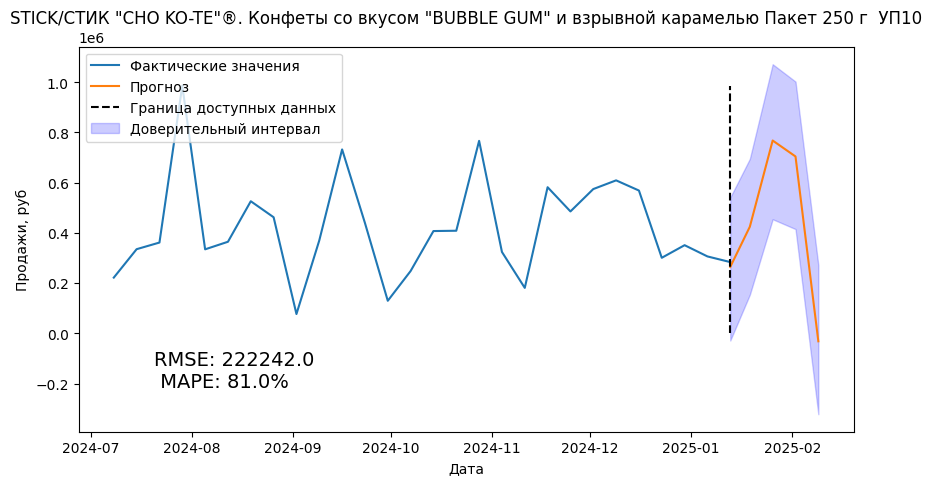

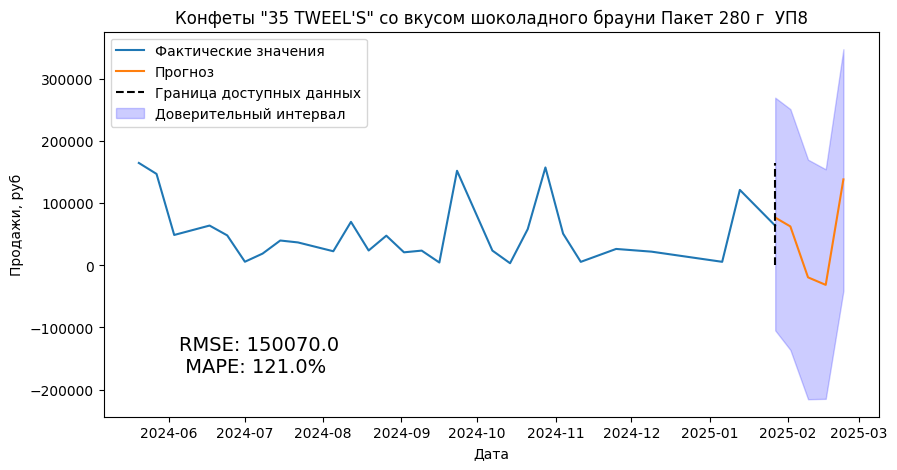

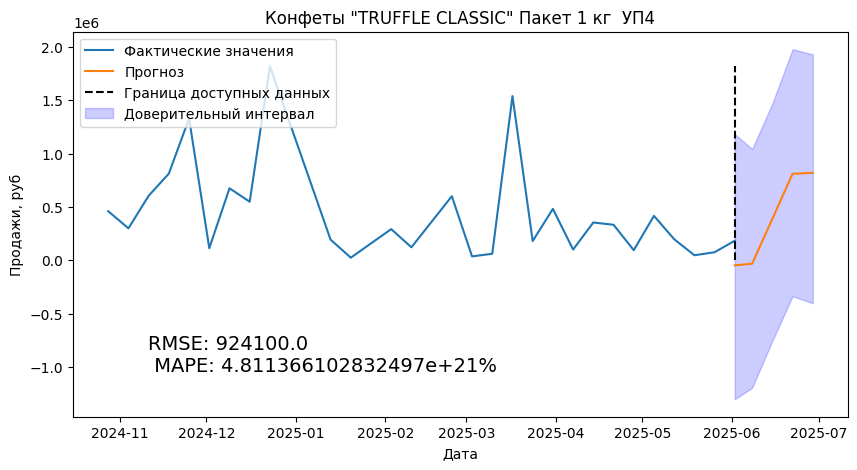

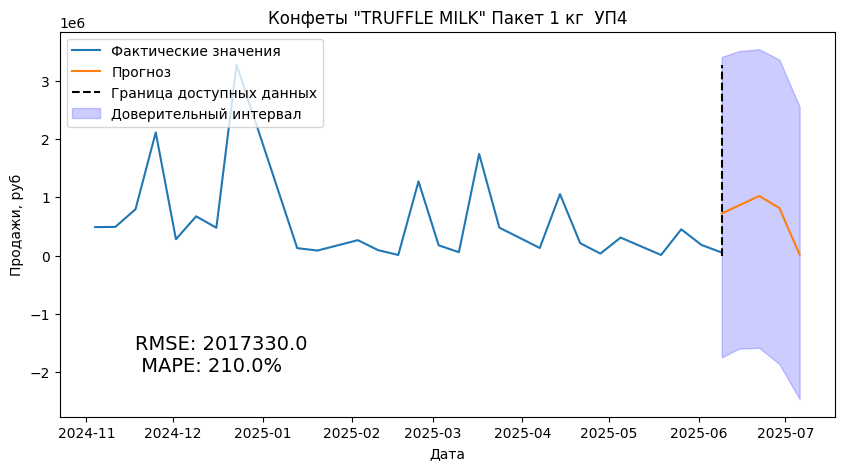

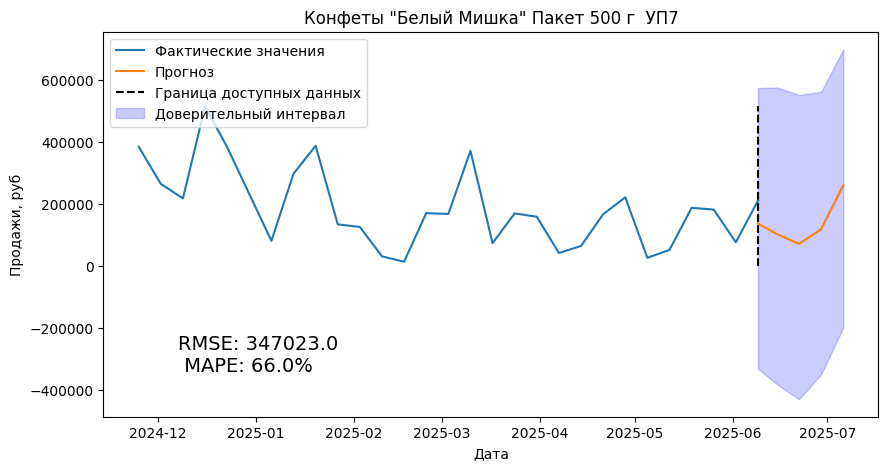

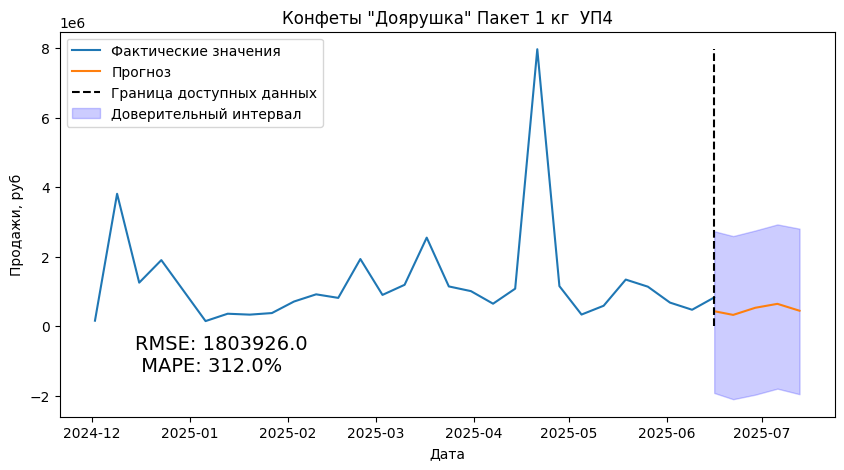

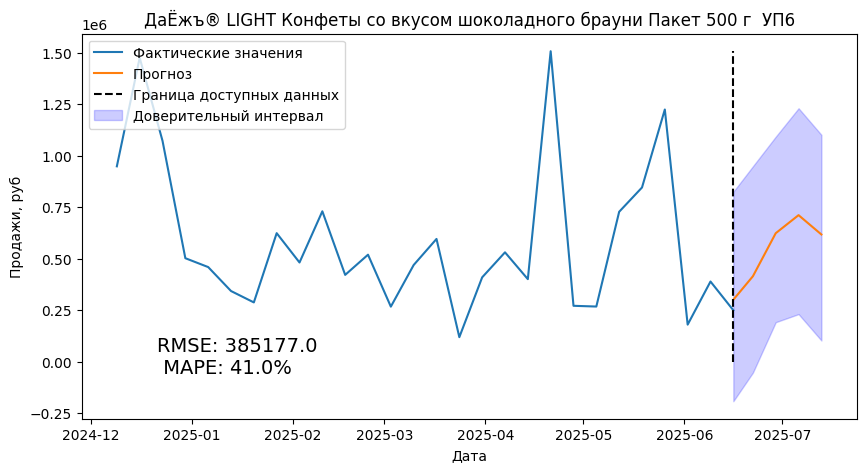

In [30]:
mae_arr, rmse_arr, mape_arr = [], [], []
for part_number in df.part_number.unique():
    df_part_number = df[df['part_number'] == part_number]
    # print(df)
    predictor = ProphetPredictor(  
                yearly_seasonality=True, 
                weekly_seasonality=False,
                n_changepoints=50,
                changepoint_range=0.95,
                changepoint_prior_scale=0.5)
    forecast = predictor.fit_predict(df_part_number, 4)
    predictor.save_predict_plot()

    forecast_train = forecast[forecast['ds'].isin(df_part_number['ds'])]
    y_true = df_part_number.set_index('ds').loc[forecast_train['ds'], 'y']
    y_pred = forecast_train['yhat']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    mae_arr.append(mae)
    rmse_arr.append(rmse)
    mape_arr.append(mape)

    # print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))

In [ ]:
df_part_number['ds'][-1:]

39777   2025-06-16
Name: ds, dtype: datetime64[ns]

(0.0, 1549561.3848791155)

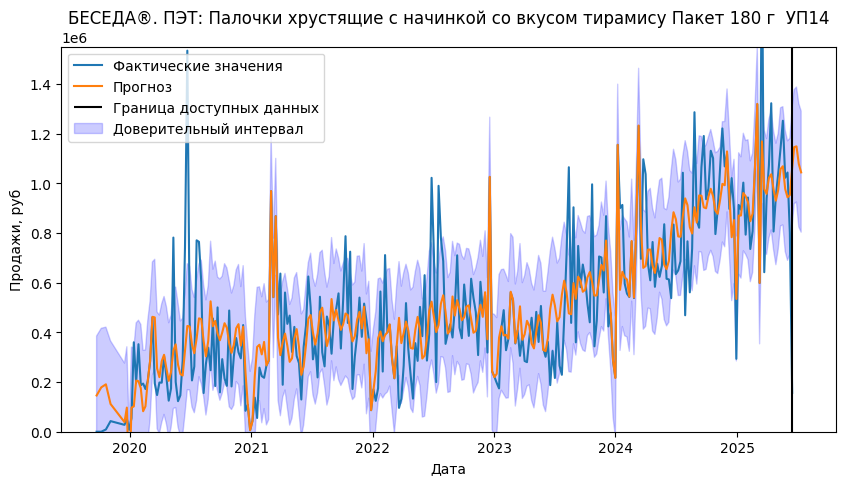

In [ ]:
cut = 1000000
last_k = 7*4
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_part_number['ds'][:cut], df_part_number['y'][:cut], label='Фактические значения')
ax.plot(forecast['ds'][:cut], forecast['yhat'][:cut], label='Прогноз')
ax.vlines(df_part_number['ds'][-1:], 0, max(df_part_number['y'][:cut]), color='k', label = 'Граница доступных данных')
ax.fill_between(forecast['ds'][:cut], forecast['yhat_lower'][:cut], 
                 forecast['yhat_upper'][:cut], color='blue', alpha=0.2, label='Доверительный интервал')
ax.legend(loc='upper left')
ax.set_xlabel('Дата')
ax.set_ylabel('Продажи, руб')
ax.set_title(df_part_number['name'].unique()[0])
# plt.xlim('')
ax.set_ylim(0, max(forecast['yhat_upper']))


In [ ]:
df_part_number['name'].unique()

array(['ДаЁжъ® LIGHT Конфеты со вкусом шоколадного брауни Пакет 500 г  УП6'],
      dtype=object)

In [ ]:
forecast_train = forecast[forecast['ds'].isin(df_part_number['ds'])]
y_true = df_part_number.set_index('ds').loc[forecast_train['ds'], 'y']
y_pred = forecast_train['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape*100:.2f}%')

MAE: 262468.88, RMSE: 385176.81, MAPE: 40.50%


Переходим к добавлению признаков и обучению модели:

In [ ]:
def predict_revenue(df: pd.DataFrame, part_number: str):
    pass